In [5]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

 #foor function and bilinear interpolation function
def floor(value):
    if value >= 0:
        return int(value)
    else:
        return int(value)-1
def bilinear(source_image, x, y):
    end_x, end_y = np.shape(source_image)
    x_f, y_f = floor(x), floor(y)
    a = x-x_f
    b = y-y_f
    if (x_f >= 0 and x_f < end_x-1 )and (y_f >= 0 and y_f < end_y-1):
        i_v = (1-a)*(1-b)*source_image[x_f, y_f] \
            + (1-a)*b*source_image[x_f, y_f+1] \
            + a*(1-b)*source_image[x_f+1, y_f] \
            + a*b*source_image[x_f+1, y_f+1]
    else:
        i_v = 0
    return i_v



In [6]:
# This function will take homogeneous coordinates and H matrix as input and return their dot product as a cartesian coordinate form
def _2D(H, x):
    x_ = np.dot(H,x)
    if x_[-1]!=0:
        return x_[0]/x_[-1], x_[1]/x_[-1]
    else:
        return 0, 0

In [7]:
#  As we are given two point correspondence. there will be two equations per point correspondence and 4 equations for 2 point correspondence.
#  we have 5 unkwons so we will create one A matric which will be 4x5 in sixe. 4 rowws and 5 coloumns. this below function will help us create
#  that A matrix. It will take 2 points and its correspondence as input
def A_m(points, c_points):
    z = len(points)
    A_mat = np.zeros((2*z, 5))
    for i in range(z):
        x, y = points[i]
        x_p, y_p = c_points[i]
        A_mat[2*i] = [x, y, 1, 0, -x_p]
        A_mat[2*i+1] = [y, -x, 0, 1, -y_p]
    return A_mat



In [8]:
#  As we had 5 unknowns in 3x3 H matrix so in this function we will take A matrix as input and calculate H matrix using Singular value
#  decomposition of Amatrix and then taking its last coloumn which will be all the unknown values and use it to construct out H matrix. This will
#  return H matrix
def compute_homography(A_matrix):
    v_t = np.linalg.svd(A_matrix)[-1]
    a, b, c, d, h = v_t[-1]
    H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)
    return H

In [9]:
#  This transform function below will take source image and H matrix as input and map all the points from taget to source to get source intensity
#  value which will be entered into a blank image created. Bilinear interpolation is used in this.
def transform_image(source_image, H):
    x, y = np.shape(source_image)
    H_inv = np.linalg.inv(H)

    target_image = np.zeros((x, y))

    for xt in range(x):
        for yt in range(y):
            vec = np.array([xt, yt, 1])
            xs, ys = _2D(H_inv, vec)
            val = bilinear(source_image, xs, ys)
            target_image[xt, yt] = val
    return target_image



In [10]:
#  This function is plotter function used to plot image
def plotter(image, title):
    plt.figure()
    plt.imshow(image, 'gray')
    plt.show()

In [11]:
#  These code segments will read the two images and create array of points and corresponding points.
img1 = imageio.imread("IMG1.png")
img2 = imageio.imread("IMG2.png")
points = np.array([[29, 124], [157, 372]])
corresponding_points = np.array([[93, 248], [328, 399]])



<ipython-input-11-e056ce5f7945>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread("IMG1.png")
<ipython-input-11-e056ce5f7945>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread("IMG2.png")


In [12]:
#  This part will store A matrix and H matrix in variables which will be used later
A = A_m(corresponding_points, points)
H = compute_homography(A)
new_image = transform_image(img2, H)

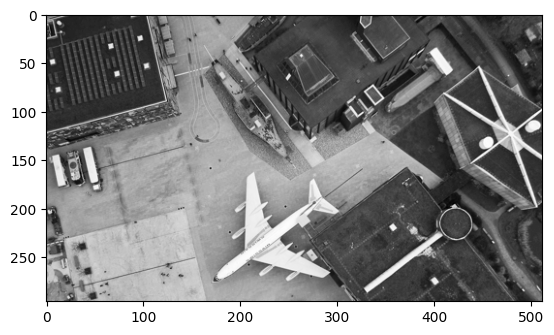

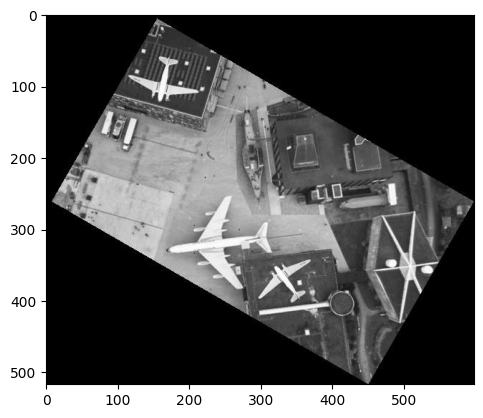

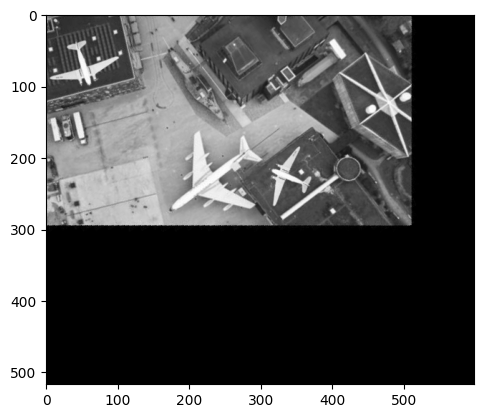

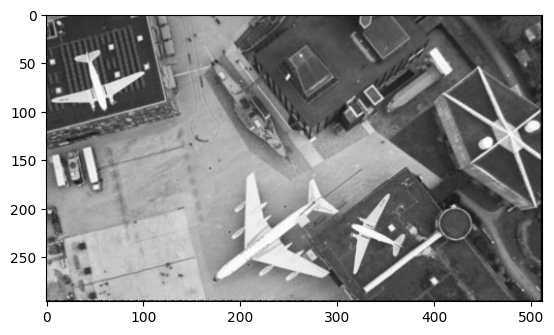

In [13]:
#  Plotting the given images and transformed image 1
plotter(img1, "Given Image 1")
plotter(img2, "Given Image 2")
plotter(new_image, "Image 2 after transformation")
#  Creating a new dummy image with zeroes and then mapping transformed image 2 to this
x1, y1 = np.shape(img1)
c = new_image[:x1, :y1]
plotter(c, "Cropped image 2 after transformation")

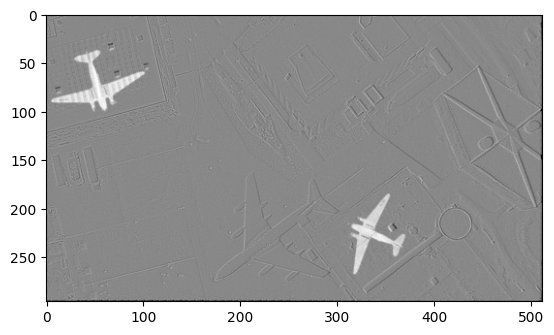

In [14]:
#  Now we have two images from same angle and position we will print out the difference between two images and plot them
diff = (c-img1)
plotter(diff, "Difference btween two images")
# As can be seen white portion is the portion which gives difference points.